# Task 3: Knowledge Distillation

## Task 3.1.1: Logit Matching

We aim to derive the following result for logit matching:

$$
\frac{\partial L_{KL}}{\partial z_i} \approx \frac{1}{N T^2} (z_i - v_i)
$$

where:

- \( z_i \): i-th logit of the student model.
- \( v_i \): i-th logit of the teacher model.
- \( T \): Temperature used to soften the probabilities.
- \( N \): Total number of logits in the layer.
- \( L_{KL} \): KL Divergence loss between teacher and student model outputs.

#### 1. KL Divergence and Softmax
The KL Divergence between two probability distributions \( p_i \) and \( q_i \) is given by:

$$
L_{KL} = \sum_i q_i \log\left(\frac{q_i}{p_i}\right)
$$

Where \( p_i \) and \( q_i \) are the soft probabilities produced by the student and teacher models respectively, and they are related to the logits \( z_i \) and \( v_i \) via the softmax function:

$$
p_i = \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)}, \quad q_i = \frac{\exp(v_i / T)}{\sum_j \exp(v_j / T)}
$$

#### 2. Logit Matching Loss
We are interested in the derivative of the KL Divergence with respect to the student model logits \( z_i \):

$$
\frac{\partial L_{KL}}{\partial z_i} = \frac{\partial}{\partial z_i} \left( \sum_i q_i \log \frac{q_i}{p_i} \right)
$$

#### 3. Approximation Using Logit Differences
We assume the logits \( z_i \) and \( v_i \) are zero-centered, allowing us to approximate the KL Divergence in terms of the logit differences:

$$
L_{KL} \approx \frac{1}{2 T^2} \sum_i (z_i - v_i)^2
$$

This approximation is valid when the logits from the student and teacher models are close.

#### 4. Taking the Derivative
The derivative of the quadratic approximation of the KL Divergence with respect to \( z_i \) is:

$$
\frac{\partial L_{KL}}{\partial z_i} \approx \frac{1}{T^2} (z_i - v_i)
$$

#### 5. Averaging Over All Logits
Since there are \( N \) logits in the layer, we average the result over all logits, leading to the final expression:

$$
\frac{\partial L_{KL}}{\partial z_i} \approx \frac{1}{N T^2} (z_i - v_i)
$$

### Conclusion
Thus, we have derived the logit matching equation, showing that the gradient of the KL Divergence is proportional to the difference between the logits of the student and teacher models, scaled by the temperature squared and the number of logits.

## Task 3.1.2: Aspects of Logit Matching

## Basic Logit Matching

### Step 1: Loading the Cifar-100 Dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader

# Define temperature parameter for logit matching
TEMPERATURE = 3.0

# Global Epoch Parameter to Ensure Fairness Across All Models
num_epochs = 3

# Load the CIFAR-100 dataset
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),  # CIFAR-100 mean and std
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 169M/169M [00:04<00:00, 35.0MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


### Step 2: Define Student and Teacher Networks


In [ ]:
teacher_model = models.vgg16(pretrained=True)
teacher_model.classifier[6] = nn.Linear(4096, 100)
teacher_model = teacher_model.to('cuda')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 223MB/s]


In [ ]:
logit_matching_student = models.vgg11()
logit_matching_student.classifier[6] = nn.Linear(4096, 100)
logit_matching_student = logit_matching_student.to('cuda')

Finetuning teacher to Cifar-100

In [ ]:
def prepare_for_finetuning(model):
  # Unfreeze only the classifier head
  for param in model.features.parameters():
      param.requires_grad = False  # Freeze the feature extraction layers

  for param in model.classifier.parameters():
      param.requires_grad = True  # Unfreeze the classifier head for training

In [ ]:
prepare_for_finetuning(teacher_model)

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Fine-tuning function with tqdm and loss tracking per epoch
def fine_tune_teacher(teacher_model, train_loader, num_epochs):
    teacher_model.train()

    # Define loss and optimizer for fine-tuning
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(teacher_model.parameters(), lr=0.0001)

    losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_samples = 0

        # Wrap the batch loop in tqdm for per-batch progress display within each epoch
        with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.cuda(), labels.cuda()

                # Zero gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = teacher_model(inputs)
                loss = criterion(outputs, labels)

                # Backpropagation and optimization
                loss.backward()
                optimizer.step()

                # Accumulate loss and total samples for the current batch
                batch_size = inputs.size(0)
                running_loss += loss.item() * batch_size
                total_samples += batch_size

                # Update tqdm with running average loss
                pbar.set_postfix(loss=running_loss / total_samples)

        # Calculate and store average loss for the epoch
        avg_loss = running_loss / total_samples
        losses.append(avg_loss)
        # print(f"Epoch [{epoch+1}/{num_epochs}] completed with Average Loss: {avg_loss:.4f}")

    print("Teacher model fine-tuning complete.")

    plt.plot(range(1, len(losses) + 1), losses, marker='o')
    plt.title('Average Loss vs. Epochs (Fine-Tuning Teacher Model)')
    plt.xlabel('Epochs')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

Epoch [3/3]: 100%|██████████| 391/391 [01:41<00:00,  3.87batch/s, loss=0.598]


Teacher model fine-tuning complete.


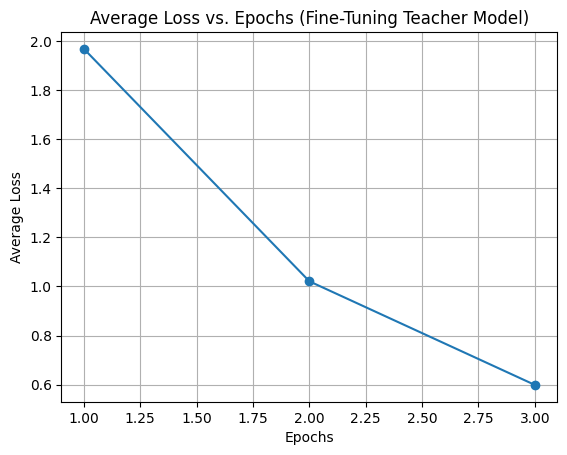

In [ ]:
# Fine-tune the teacher model
fine_tune_teacher(teacher_model, train_loader, num_epochs)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# torch.save(teacher_model, "/content/drive/MyDrive/teacher_model.pth")

In [ ]:
# teacher_model = torch.load("/content/drive/MyDrive/teacher_model.pth")

### Step 3: Knowledge Distillation Using Logit Matching

In [ ]:
# Define loss function for logit matching
class DistillationLoss(nn.Module):
    def __init__(self, temperature):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.kl_divergence = nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_logits, teacher_logits):
        # Apply temperature scaling to logits
        student_probs = nn.functional.log_softmax(student_logits / self.temperature, dim=1)
        teacher_probs = nn.functional.softmax(teacher_logits / self.temperature, dim=1)

        # Calculate distillation loss (KL Divergence between softened outputs)
        distillation_loss = self.kl_divergence(student_probs, teacher_probs) * (self.temperature ** 2)
        return distillation_loss

distillation_loss_fn = DistillationLoss(TEMPERATURE)

### Step 4: Training Loop

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Training loop with tqdm and loss tracking per epoch
def train_LM(student_model, teacher_model, train_loader, distillation_loss_fn, num_epochs, lambda_kd=0.5):
    # Define optimizer for the student model
    optimizer = optim.AdamW(student_model.parameters(), lr=0.0001)

    # Store losses per epoch
    epoch_losses = []

    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        student_model.train()
        teacher_model.eval()

        running_loss = 0.0
        total_samples = 0

        # Wrap the batch loop in tqdm for progress display
        with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.cuda(), labels.cuda()

                # Forward pass through teacher and student
                with torch.no_grad():
                    teacher_outputs = teacher_model(inputs)

                student_outputs = student_model(inputs)

                # Compute distillation loss
                soft_loss = distillation_loss_fn(student_outputs, teacher_outputs) * lambda_kd
                crit_loss = criterion(student_outputs, labels)

                loss = soft_loss + crit_loss

                # Backpropagation and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Accumulate loss and update tqdm display
                batch_size = inputs.size(0)
                running_loss += loss.item() * batch_size
                total_samples += batch_size
                pbar.set_postfix(loss=running_loss / total_samples)

        # Calculate and store average loss for the epoch
        avg_loss = running_loss / total_samples
        epoch_losses.append(avg_loss)

    print("Training complete.")

    # Plot losses vs. epochs
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
    plt.title('Average Loss (Student Model Logit Matching Training)')
    plt.xlabel('Epochs')
    plt.ylabel('Average Loss')
    plt.show()

Epoch [3/3]: 100%|██████████| 391/391 [02:24<00:00,  2.70batch/s, loss=5.21]

Training complete.


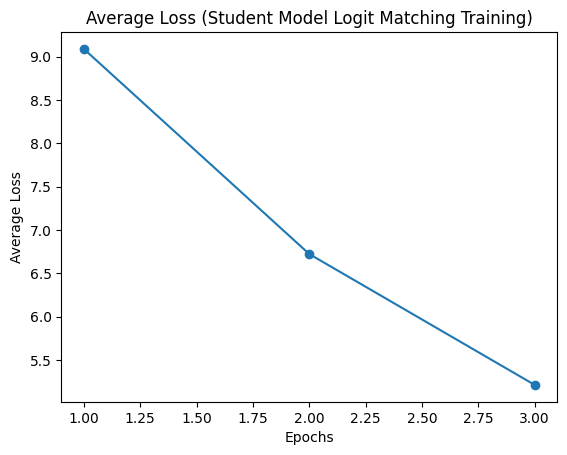

In [ ]:
# Train the student model
train_LM(logit_matching_student, teacher_model, train_loader, distillation_loss_fn, num_epochs)

In [ ]:
# torch.save(logit_matching_student, "/content/drive/MyDrive/logit_matching_student.pth")

In [ ]:
# logit_matching_student = torch.load("/content/drive/MyDrive/logit_matching_student.pth")

### Step 5: Testing the Model

In [ ]:
# Test the student model's accuracy on the test set
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [ ]:
# Evaluate the Student Model after training
logit_matching_acc = evaluate(logit_matching_student, test_loader)
print(f'Accuracy of the logit matching student model on the test set: {logit_matching_acc:.2f}%')

# Evaluate Teacher Model Itself
teacher_acc = evaluate(teacher_model, test_loader)
print(f'Accuracy of the teacher model on the test set: {teacher_acc:.2f}%')

Accuracy of the logit matching student model on the test set: 42.27%
Accuracy of the teacher model on the test set: 67.78%


### Label Smoothing

Modified Distillation Loss class to account for smoothed teacher logits

In [ ]:
# Define loss function for logit matching with smoothed teacher probabilities
class DistillationLoss_smooth(nn.Module):
    def __init__(self, temperature):
        super(DistillationLoss_smooth, self).__init__()
        self.temperature = temperature
        self.kl_divergence = nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_logits, teacher_probs):
        # Apply temperature scaling to student logits
        student_probs = nn.functional.log_softmax(student_logits / self.temperature, dim=1)

        # Scale teacher probabilities by temperature
        teacher_probs_scaled = teacher_probs / self.temperature

        # Calculate distillation loss (KL Divergence between student and smoothed teacher outputs)
        distillation_loss = self.kl_divergence(student_probs, teacher_probs_scaled) * (self.temperature ** 2)
        return distillation_loss

# Instantiate the loss function with a temperature value
distillation_loss_fn = DistillationLoss_smooth(temperature=TEMPERATURE)  # Adjust temperature as needed

Re-Initialising Student Model

In [ ]:
label_smoothed_student = models.vgg11()

# Modify the models for CIFAR-100 (100 output classes)
label_smoothed_student.classifier[6] = nn.Linear(4096, 100)

label_smoothed_student = label_smoothed_student.to('cuda')

Label Smoothing Function

In [ ]:
# Define a function to apply label smoothing to teacher logits
def apply_label_smoothing(teacher_logits, smoothing=0.1):
    """
    Apply label smoothing to the teacher logits.
    :param teacher_logits: Logits from the teacher model [batch_size, num_classes]
    :param smoothing: Smoothing factor (default=0.1)
    :return: Smoothed probabilities
    """

    # Convert logits to probabilities
    teacher_probs = F.softmax(teacher_logits, dim=-1)

    # Apply label smoothing
    num_classes = teacher_probs.size(-1)
    smoothed_probs = (1 - smoothing) * teacher_probs + (smoothing / num_classes)

    return smoothed_probs

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Training loop with label-smoothed teacher logits
def train_with_smoothed_teacher(student_model, teacher_model, train_loader, distillation_loss_fn, num_epochs, smoothing=0.1, weight=0.5):
    # Define optimizer for the student model
    optimizer = optim.AdamW(student_model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    losses = []

    for epoch in range(num_epochs):
        student_model.train()
        teacher_model.eval()

        running_loss = 0.0
        total_samples = 0

        with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:

            for inputs, labels in pbar:
                inputs, labels = inputs.cuda(), labels.cuda()

                # Forward pass through teacher and student
                with torch.no_grad():
                    teacher_logits = teacher_model(inputs)
                    teacher_probs_smoothed = apply_label_smoothing(teacher_logits, smoothing=smoothing)

                student_outputs = student_model(inputs)

                # Compute distillation loss using smoothed teacher probabilities
                distill_loss = distillation_loss_fn(student_outputs, teacher_probs_smoothed) * 0.5
                crit_loss = criterion(student_outputs, labels)

                loss = distill_loss + crit_loss

                # Backpropagation and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Accumulate loss and update tqdm display
                batch_size = inputs.size(0)
                running_loss += loss.item() * batch_size
                total_samples += batch_size
                pbar.set_postfix(loss=running_loss / total_samples)

        # Calculate average loss for the epoch
        avg_loss = running_loss / total_samples
        losses.append(avg_loss)

    print("Training with label-smoothed teacher logits complete.")

    plt.plot(range(1, len(losses) + 1), losses, marker='o')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

Epoch [3/3]: 100%|██████████| 391/391 [02:25<00:00,  2.69batch/s, loss=4.11]

Training with label-smoothed teacher logits complete.


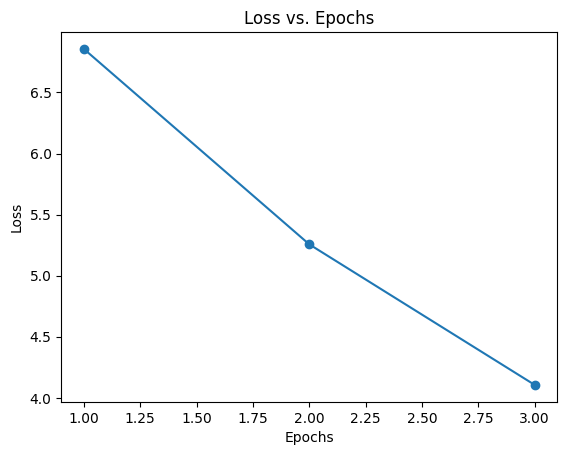

In [ ]:
# Train the student model with smoothed teacher logits
train_with_smoothed_teacher(label_smoothed_student, teacher_model, train_loader, distillation_loss_fn, num_epochs, smoothing=0.1)

In [ ]:
label_smoothed_acc = evaluate(label_smoothed_student, test_loader)
print(f'Accuracy of the student model on the test set with smoothed teacher logits: {label_smoothed_acc:.2f}%')

acc = evaluate(teacher_model, test_loader)
print(f'Accuracy of the teacher model on the test set: {acc:.2f}%')

Accuracy of the student model on the test set with smoothed teacher logits: 38.69%
Accuracy of the teacher model on the test set: 67.78%


## Decoupled Knowledge Distillation

Re-initialising the Student

In [ ]:
dkd_student = models.vgg11()

# Modify the models for CIFAR-100 (100 output classes)
dkd_student.classifier[6] = nn.Linear(4096, 100)

dkd_student = dkd_student.to('cuda')

Decoupled KD Loss Class

In [ ]:
import torch
import torch.nn.functional as F

class DecoupledKnowledgeDistillationLoss(nn.Module):
    def __init__(self, temperature, alpha=0.5, beta=0.5):
        super(DecoupledKnowledgeDistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha  # weight for target loss
        self.beta = beta  # weight for non-target loss

    def forward(self, student_logits, teacher_logits, labels):
        """
        Computes DKD loss between the student and teacher logits for decoupled knowledge distillation.
        :param student_logits: Logits from the student model [batch_size, num_classes]
        :param teacher_logits: Logits from the teacher model [batch_size, num_classes]
        :param labels: Ground truth labels for the batch [batch_size]
        :return: Decoupled Knowledge Distillation loss
        """
        # Apply temperature scaling
        student_probs = F.log_softmax(student_logits / self.temperature, dim=1)
        teacher_probs = F.softmax(teacher_logits / self.temperature, dim=1)

        # Select the target class probabilities (true label) for each example
        batch_size = labels.size(0)
        target_class_mask = torch.zeros_like(student_probs)
        target_class_mask[torch.arange(batch_size), labels] = 1.0

        # Target loss: KL divergence for the true class
        target_loss = F.kl_div(
            (student_probs * target_class_mask).sum(dim=1),
            (teacher_probs * target_class_mask).sum(dim=1),
            reduction='batchmean'
        )

        # Non-target loss: KL divergence for all other classes
        non_target_loss = F.kl_div(
            (student_probs * (1 - target_class_mask)),
            (teacher_probs * (1 - target_class_mask)),
            reduction='batchmean'
        )

        # Weighted sum of target and non-target losses
        dkd_loss = (self.alpha * target_loss + self.beta * non_target_loss) * (self.temperature ** 2)
        return dkd_loss

# Instantiate DKD loss with temperature and weighting parameters
dkd_loss_fn = DecoupledKnowledgeDistillationLoss(temperature=TEMPERATURE, alpha=0.5, beta=0.5)

Train

In [ ]:
# Train the student model using DKD loss
def train_with_dkd(student_model, teacher_model, train_loader, dkd_loss_fn, num_epochs, weight=0.5):
    # Optimiser, Criterion
    optimizer = optim.AdamW(student_model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    losses = []

    for epoch in range(num_epochs):
        student_model.train()
        teacher_model.eval()
        running_loss = 0.0
        total_samples = 0

        with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.cuda(), labels.cuda()

                # Forward pass through teacher and student
                with torch.no_grad():
                    teacher_logits = teacher_model(inputs)

                student_logits = student_model(inputs)

                # Compute DKD loss
                dkd_loss = dkd_loss_fn(student_logits, teacher_logits, labels) * weight
                crit_loss = criterion(student_logits, labels)

                loss = dkd_loss + crit_loss

                # Backpropagation and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Accumulate loss and update tqdm display
                batch_size = inputs.size(0)
                running_loss += loss.item() * batch_size
                total_samples += batch_size
                pbar.set_postfix(loss=running_loss / total_samples)

        # Calculate and store average loss for the epoch
        avg_loss = running_loss / total_samples
        losses.append(avg_loss)

    print("Training with Decoupled Knowledge Distillation complete.")

    # Plot loss over epochs
    plt.plot(range(1, len(losses) + 1), losses, marker='o')
    plt.title('Loss vs. Epochs (DKD)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

Epoch [3/3]: 100%|██████████| 391/391 [02:25<00:00,  2.68batch/s, loss=3.97]

Training with Decoupled Knowledge Distillation complete.


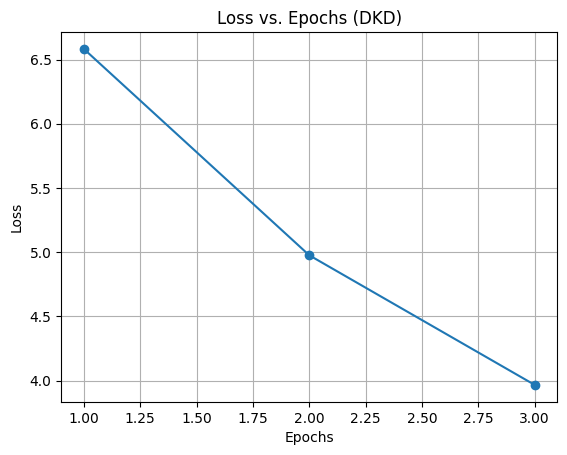

In [ ]:
# Train the student model with DKD loss
train_with_dkd(dkd_student, teacher_model, train_loader, dkd_loss_fn, num_epochs)

In [ ]:
dkd_acc = evaluate(dkd_student, test_loader)
print(f'Accuracy of the student model on the test set with DKD: {dkd_acc:.2f}%')

acc = evaluate(teacher_model, test_loader)
print(f'Accuracy of the teacher model on the test set: {acc:.2f}%')

Accuracy of the student model on the test set with DKD: 41.06%
Accuracy of the teacher model on the test set: 67.78%


## 3.2: Comparing Performance of SOTA Approaches

### Hint-based Distillation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Hyperparameters
HINT_LAYER_TEACHER = 17 # Middle Layer
GUIDED_LAYER_STUDENT = 11 # Middle Layer

In [ ]:
# student (VGG11) models
hint_student = models.vgg11()

# Modify models to output 100 classes (for CIFAR-100)
hint_student.classifier[6] = nn.Linear(4096, 100)

# Send models to GPU
hint_student = hint_student.to('cuda')

In [ ]:
# Regressor to map student's guided layer output to teacher's hint layer
class HintRegressor(nn.Module):
    def __init__(self, student_dim, teacher_dim):
        super(HintRegressor, self).__init__()
        self.regressor = nn.Conv2d(student_dim, teacher_dim, kernel_size=1)

    def forward(self, x):
        return self.regressor(x)

# Initialize the regressor
# Assume teacher's hint layer has 256 channels, and student's guided layer has 128 channels
regressor = HintRegressor(student_dim=128, teacher_dim=256).to('cuda')

In [ ]:
# Extract feature maps for hint and guided layers
def extract_features(model, layer_idx, x):
    for idx, layer in enumerate(model.features):
        x = layer(x)
        if idx == layer_idx:
            break
    return x

# Train guided layer to match hint layer
def train_hint(student_model, teacher_model, regressor, train_loader, num_epochs, hint_weight=0.5):
    student_model.train()
    teacher_model.eval()
    losses = []

    # Define Mean Squared Error loss for hint training
    hint_loss_fn = nn.MSELoss()
    criterion = nn.CrossEntropyLoss()
    optimizer_hint = optim.AdamW(student_model.parameters(), lr=0.0001)

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_samples = 0
        with tqdm(train_loader, desc=f"Hint Training Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
            for inputs, targets in pbar:
                inputs = inputs.to('cuda')
                targets = targets.to('cuda')

                # Get teacher and student feature maps
                teacher_features = extract_features(teacher_model, HINT_LAYER_TEACHER, inputs)
                student_features = extract_features(student_model, GUIDED_LAYER_STUDENT, inputs)

                student_outputs = student_model(inputs)

                #student_features = regressor(student_features)

                # Calculate hint loss
                hint_loss = hint_loss_fn(student_features, teacher_features) * hint_weight
                crit_loss = criterion(student_outputs, targets)

                loss = hint_loss + crit_loss

                # Optimize
                optimizer_hint.zero_grad()
                loss.backward()
                optimizer_hint.step()

                # Track loss
                batch_size = inputs.size(0)
                running_loss += loss.item() * batch_size
                total_samples += batch_size
                pbar.set_postfix(loss=running_loss / total_samples)

        avg_loss = running_loss / total_samples
        losses.append(avg_loss)

    plt.plot(range(1, len(losses) + 1), losses, marker='o')
    plt.title('Average Hint Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

Hint Training Epoch [3/3]: 100%|██████████| 391/391 [02:53<00:00,  2.26batch/s, loss=7.64]


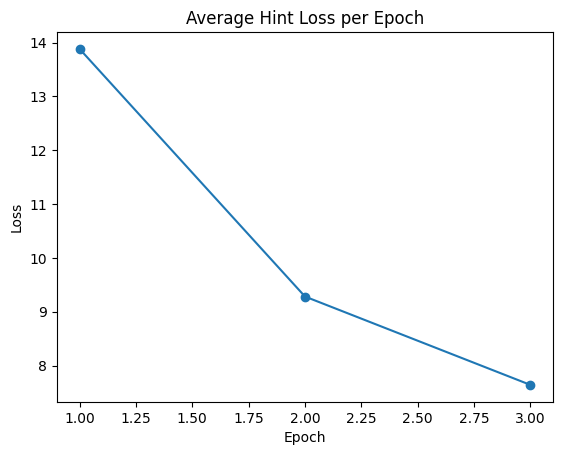

In [ ]:
# Run hint training
train_hint(hint_student, teacher_model, regressor, train_loader, num_epochs, hint_weight=0.5)

In [ ]:
# torch.save(hint_student, "/content/drive/MyDrive/hint_student.pth")

In [ ]:
# hint_student = torch.load("/content/drive/MyDrive/hint_student.pth")

In [ ]:
# Evaluate the Student Model after training
hint_acc = evaluate(hint_student, test_loader)
print(f'Accuracy of the student model with hints on the test set: {hint_acc:.2f}%')

acc = evaluate(teacher_model, test_loader)
print(f'Accuracy of the teacher model on the test set: {acc:.2f}%')

Accuracy of the student model with hints on the test set: 47.97%
Accuracy of the teacher model on the test set: 67.78%


## Contrastive Representation Distillation

In [ ]:
crd_student = models.vgg11()

# Modify the models for CIFAR-100 (100 output classes)
crd_student.classifier[6] = nn.Linear(4096, 100)

crd_student = crd_student.to('cuda')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


'''
Modified from https://github.com/HobbitLong/RepDistiller/tree/master/crd
'''
class CRD(nn.Module):
	'''
	Contrastive Representation Distillation
	https://openreview.net/pdf?id=SkgpBJrtvS

	includes two symmetric parts:
	(a) using teacher as anchor, choose positive and negatives over the student side
	(b) using student as anchor, choose positive and negatives over the teacher side

	Args:
		s_dim: the dimension of student's feature
		t_dim: the dimension of teacher's feature
		feat_dim: the dimension of the projection space
		nce_n: number of negatives paired with each positive
		nce_t: the temperature
		nce_mom: the momentum for updating the memory buffer
		n_data: the number of samples in the training set, which is the M in Eq.(19)
	'''
	def __init__(self, s_dim, t_dim, feat_dim, nce_n, nce_t, nce_mom, n_data):
		super(CRD, self).__init__()
		self.embed_s = Embed(s_dim, feat_dim)
		self.embed_t = Embed(t_dim, feat_dim)
		self.contrast = ContrastMemory(feat_dim, n_data, nce_n, nce_t, nce_mom)
		self.criterion_s = ContrastLoss(n_data)
		self.criterion_t = ContrastLoss(n_data)

	def forward(self, feat_s, feat_t, idx, sample_idx):
		feat_s = self.embed_s(feat_s)
		feat_t = self.embed_t(feat_t)
		out_s, out_t = self.contrast(feat_s, feat_t, idx, sample_idx)
		loss_s = self.criterion_s(out_s)
		loss_t = self.criterion_t(out_t)
		loss = loss_s + loss_t

		return loss


class Embed(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(Embed, self).__init__()
		self.linear = nn.Linear(in_dim, out_dim)

	def forward(self, x):
		x = x.view(x.size(0), -1)
		x = self.linear(x)
		x = F.normalize(x, p=2, dim=1)

		return x


class ContrastLoss(nn.Module):
	'''
	contrastive loss, corresponding to Eq.(18)
	'''
	def __init__(self, n_data, eps=1e-7):
		super(ContrastLoss, self).__init__()
		self.n_data = n_data
		self.eps = eps

	def forward(self, x):
		bs = x.size(0)
		N  = x.size(1) - 1
		M  = float(self.n_data)

		# loss for positive pair
		pos_pair = x.select(1, 0)
		log_pos  = torch.div(pos_pair, pos_pair.add(N / M + self.eps)).log_()

		# loss for negative pair
		neg_pair = x.narrow(1, 1, N)
		log_neg  = torch.div(neg_pair.clone().fill_(N / M), neg_pair.add(N / M + self.eps)).log_()

		loss = -(log_pos.sum() + log_neg.sum()) / bs

		return loss


class ContrastMemory(nn.Module):
	def __init__(self, feat_dim, n_data, nce_n, nce_t, nce_mom):
		super(ContrastMemory, self).__init__()
		self.N = nce_n
		self.T = nce_t
		self.momentum = nce_mom
		self.Z_t = None
		self.Z_s = None

		stdv = 1. / math.sqrt(feat_dim / 3.)
		self.register_buffer('memory_t', torch.rand(n_data, feat_dim).mul_(2 * stdv).add_(-stdv))
		self.register_buffer('memory_s', torch.rand(n_data, feat_dim).mul_(2 * stdv).add_(-stdv))

	def forward(self, feat_s, feat_t, idx, sample_idx):
		bs = feat_s.size(0)
		feat_dim = self.memory_s.size(1)
		n_data = self.memory_s.size(0)

		# using teacher as anchor
		weight_s = torch.index_select(self.memory_s, 0, sample_idx.view(-1)).detach()
		weight_s = weight_s.view(bs, self.N + 1, feat_dim)
		out_t = torch.bmm(weight_s, feat_t.view(bs, feat_dim, 1))
		out_t = torch.exp(torch.div(out_t, self.T)).squeeze().contiguous()

		# using student as anchor
		weight_t = torch.index_select(self.memory_t, 0, sample_idx.view(-1)).detach()
		weight_t = weight_t.view(bs, self.N + 1, feat_dim)
		out_s = torch.bmm(weight_t, feat_s.view(bs, feat_dim, 1))
		out_s = torch.exp(torch.div(out_s, self.T)).squeeze().contiguous()

		# set Z if haven't been set yet
		if self.Z_t is None:
			self.Z_t = (out_t.mean() * n_data).detach().item()
		if self.Z_s is None:
			self.Z_s = (out_s.mean() * n_data).detach().item()

		out_t = torch.div(out_t, self.Z_t)
		out_s = torch.div(out_s, self.Z_s)

		# update memory
		with torch.no_grad():
			pos_mem_t = torch.index_select(self.memory_t, 0, idx.view(-1))
			pos_mem_t.mul_(self.momentum)
			pos_mem_t.add_(torch.mul(feat_t, 1 - self.momentum))
			pos_mem_t = F.normalize(pos_mem_t, p=2, dim=1)
			self.memory_t.index_copy_(0, idx, pos_mem_t)

			pos_mem_s = torch.index_select(self.memory_s, 0, idx.view(-1))
			pos_mem_s.mul_(self.momentum)
			pos_mem_s.add_(torch.mul(feat_s, 1 - self.momentum))
			pos_mem_s = F.normalize(pos_mem_s, p=2, dim=1)
			self.memory_s.index_copy_(0, idx, pos_mem_s)

		return out_s, out_t

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import vgg11, vgg16

def extract_features_crd(model, x):
    x = model.features(x)
    x = model.avgpool(x)
    x = torch.flatten(x, 1)
    x = model.classifier[:5](x)  # Extract features before the final classification layer
    return x

# Training loop with tqdm and loss tracking per epoch
def train_CRD(student_model, teacher_model, train_loader, num_epochs, lambda_kd=0.5):
    # Initialize CRD module
    s_dim, t_dim, feat_dim, nce_n, nce_t, nce_mom, n_data = 4096, 4096, 128, 4096, 0.07, 0.5, len(train_dataset)
    crd_distillation = CRD(s_dim, t_dim, feat_dim, nce_n, TEMPERATURE, nce_mom, n_data).cuda()

    # Define optimizer for the student model
    optimizer = optim.AdamW(student_model.parameters(), lr=0.0001)

    # Store losses per epoch
    epoch_losses = []
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        student_model.train()
        teacher_model.eval()

        running_loss = 0.0
        total_samples = 0

        # Wrap the batch loop in tqdm for progress display
        with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.cuda(), labels.cuda()

                # Forward pass through teacher and student to get features
                with torch.no_grad():
                    feat_t = extract_features_crd(teacher_model, inputs)

                feat_s = extract_features_crd(student_model, inputs)

                # Get student outputs for classification loss
                student_outputs = student_model(inputs)

                # Get features for CRD loss
                idx = torch.arange(0, inputs.size(0)).cuda()  # Index for memory buffer update
                sample_idx = torch.randint(0, n_data, (inputs.size(0), crd_distillation.contrast.N + 1)).cuda()

                # Compute CRD distillation loss
                crd_loss = crd_distillation(feat_s, feat_t, idx, sample_idx) * lambda_kd
                crit_loss = criterion(student_outputs, labels)

                # Total loss
                loss = crd_loss + crit_loss

                # Backpropagation and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Accumulate loss and update tqdm display
                batch_size = inputs.size(0)
                running_loss += loss.item() * batch_size
                total_samples += batch_size
                pbar.set_postfix(loss=running_loss / total_samples)

        # Calculate and store average loss for the epoch
        avg_loss = running_loss / total_samples
        epoch_losses.append(avg_loss)

    print("Training complete.")

    # Plot losses vs. epochs
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
    plt.title('Average Loss (CRD-based KD Training)')
    plt.xlabel('Epochs')
    plt.ylabel('Average Loss')
    plt.show()

Epoch [3/3]: 100%|██████████| 391/391 [03:14<00:00,  2.01batch/s, loss=11.9]

Training complete.


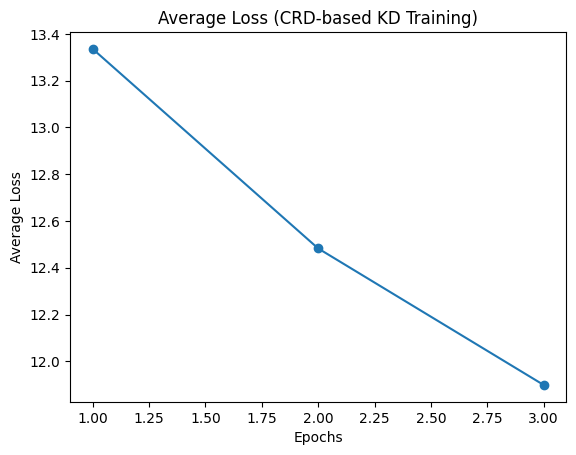

In [ ]:
# Train the student model with CRD-based KD
train_CRD(crd_student, teacher_model, train_loader, num_epochs)

In [ ]:
# torch.save(crd_student, "/content/drive/MyDrive/crd_student.pth")

In [ ]:
# crd_student = torch.load("/content/drive/MyDrive/crd_student.pth")

In [ ]:
# Evaluate the Student Model after training
crd_acc = evaluate(crd_student, test_loader)
print(f'Accuracy of the student model with CRD on the test set: {crd_acc:.2f}%')

acc = evaluate(teacher_model, test_loader)
print(f'Accuracy of the teacher model on the test set: {acc:.2f}%')

Accuracy of the student model with CRD on the test set: 38.86%
Accuracy of the teacher model on the test set: 67.78%


## Task 3.3: Comparing Probability Distributions

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def compute_kl_divergence(teacher_probs, student_probs):
    return F.kl_div(teacher_probs.log(), student_probs, reduction='batchmean')

def evaluate_distribution_alignment(teacher_model, students, test_loader, temperature=3.0):
    # Ensure models are in evaluation mode
    teacher_model.eval()
    for model in students.values():
        model.eval()

    divergence_scores = {name: 0.0 for name in students.keys()}
    total_samples = 0

    with torch.no_grad():
        for inputs, _ in tqdm(test_loader, desc="Evaluating Divergences"):
            inputs = inputs.cuda()

            # Get softened probabilities from teacher model
            teacher_logits = teacher_model(inputs) / temperature
            teacher_probs = F.softmax(teacher_logits, dim=1)

            for name, student_model in students.items():
                student_logits = student_model(inputs) / temperature
                student_probs = F.softmax(student_logits, dim=1)

                # Compute KL divergence between teacher and student
                kl_divergence = compute_kl_divergence(teacher_probs, student_probs)
                divergence_scores[name] += kl_divergence.item() * inputs.size(0)

            total_samples += inputs.size(0)

    # Average the divergence scores over all samples
    for name in divergence_scores:
        divergence_scores[name] /= total_samples

    return divergence_scores

In [ ]:
# logit_matching_student = torch.load("/content/drive/MyDrive/logit_matching_student.pth")
# hint_student = torch.load("/content/drive/MyDrive/hint_student.pth")
# crd_student = torch.load("/content/drive/MyDrive/crd_student.pth")

In [ ]:
independent_student = models.vgg11()

# Modify the models for CIFAR-100 (100 output classes)
independent_student.classifier[6] = nn.Linear(4096, 100)

independent_student = independent_student.to('cuda')

In [ ]:
# prepare_for_finetuning(independent_student)

Epoch [3/3]: 100%|██████████| 391/391 [01:54<00:00,  3.42batch/s, loss=2.59]


Teacher model fine-tuning complete.


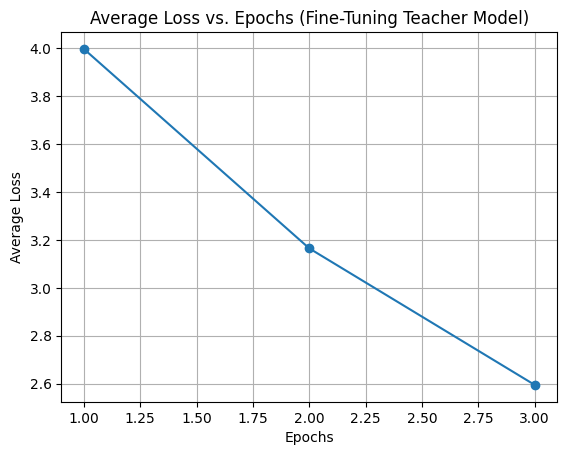

In [ ]:
# Finetune the teacher model on the jittered dataset
fine_tune_teacher(independent_student, train_loader, num_epochs)

In [ ]:
# Evaluate the Student Model after training
acc = evaluate(independent_student, test_loader)
print(f'Accuracy of the finetuned student model on the test set: {acc:.2f}%')

Accuracy of the finetuned student model on the test set: 39.03%


In [ ]:
# torch.save(logit_matching_student, "/content/drive/MyDrive/logit_matching_student.pth")
# torch.save(hint_student, "/content/drive/MyDrive/hint_student.pth")
# torch.save(crd_student, "/content/drive/MyDrive/crd_student.pth")
# torch.save(independent_student, "/content/drive/MyDrive/independent_student.pth")

In [ ]:
# logit_matching_student = torch.load("/content/drive/MyDrive/logit_matching_student.pth")
# hint_student = torch.load("/content/drive/MyDrive/hint_student.pth")
# crd_student = torch.load("/content/drive/MyDrive/crd_student.pth")
# independent_student = torch.load("/content/drive/MyDrive/independent_student.pth")

In [ ]:
# Dictionary to store the student models for evaluation
students = {
    "Logit Matching": logit_matching_student,
    "Hint": hint_student,
    "CRD": crd_student,
    "Independent Student": independent_student
}

# Call the evaluation function to compute divergence scores
divergence_scores = evaluate_distribution_alignment(teacher_model, students, test_loader, temperature=TEMPERATURE)

# Print the results for each student model
print("\nKL Divergence Scores (Average over Query Images):")
for name, score in divergence_scores.items():
    print(f"{name}: {score:.4f}")

Evaluating Divergences: 100%|██████████| 79/79 [00:30<00:00,  2.56it/s]


KL Divergence Scores (Average over Query Images):
Logit Matching: 0.4552
Hint: 0.4829
CRD: 0.5995
Independent Student: 0.6117


In analyzing these KL divergence scores, which measure the dissimilarity between the distributions of each student model and the teacher model, we can see clear patterns indicating the effectiveness of different KD methods.

### Logit Matching:

With a score of 0.4552, the logit matching student model shows the closest alignment to the teacher’s predictions, achieving the lowest KL divergence. This suggests that logit matching effectively aligns the student’s output distribution with the teacher’s, making it the most successful KD approach here.

### Hint-based Distillation:

The hint-based student model has a KL divergence of 0.4829, which is slightly higher than logit matching. This result shows that hint-based distillation also effectively aligns with the teacher’s distribution, but not as closely as logit matching. It remains significantly closer to the teacher's distribution compared to other approaches.

### Contrastive Representation Distillation (CRD):

With a score of 0.5995, the CRD student model has a higher KL divergence, suggesting less alignment with the teacher’s predictions than logit matching and hint-based distillation. CRD, however, still demonstrates closer alignment than the independent student model, indicating it retains some benefit from the KD approach.

### Independent Student:

The independent student model, with the highest KL divergence of 0.6117, exhibits the least similarity to the teacher’s distribution. This emphasizes that knowledge distillation significantly enhances distributional alignment compared to training the student model independently.

### Summary

All three KD methods improve alignment with the teacher's predictions compared to the independent student model. Logit matching, in particular, achieves the closest alignment, making it the most effective approach among the three tested. The difference between logit matching and hint-based distillation is relatively small, but both are notably more aligned than CRD, which still performs better than the independent approach.

## Task 3.4: Examining Localization Knowledge Transfer

### GradCAM Visualisations

True Label: 78


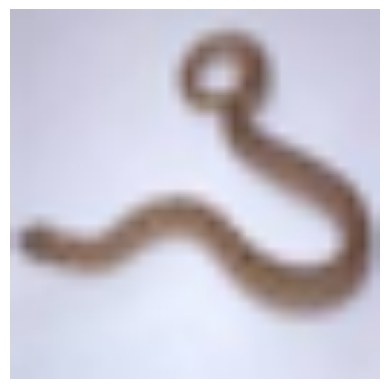

True Label: 75


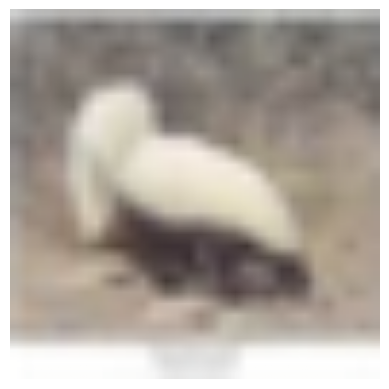

True Label: 6


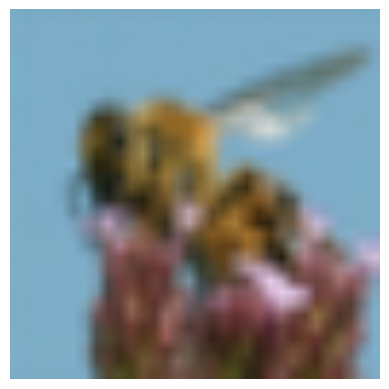

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torchvision import transforms

# Get a single batch of images and labels from the test loader
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Select three random indices from the batch
random_indices = random.sample(range(images.size(0)), 3)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# If your model requires GPU, transfer the tensors to the GPU
selected_images = selected_images.to('cuda')
selected_labels = selected_labels.to('cuda')

# Function to denormalize and display the image
def imshow(tensor):
    tensor = tensor.cpu().clone()  # Clone to CPU
    unnormalize = transforms.Normalize(
        mean=[-0.5071 / 0.2675, -0.4867 / 0.2565, -0.4408 / 0.2761],
        std=[1 / 0.2675, 1 / 0.2565, 1 / 0.2761]
    )
    image = unnormalize(tensor)
    image = np.transpose(image.numpy(), (1, 2, 0))  # Convert from CHW to HWC format
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Display each selected image with its label
for i in range(3):
    print(f"True Label: {selected_labels[i].item()}")
    imshow(selected_images[i])  # Pass the image without adding an extra batch dimension

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


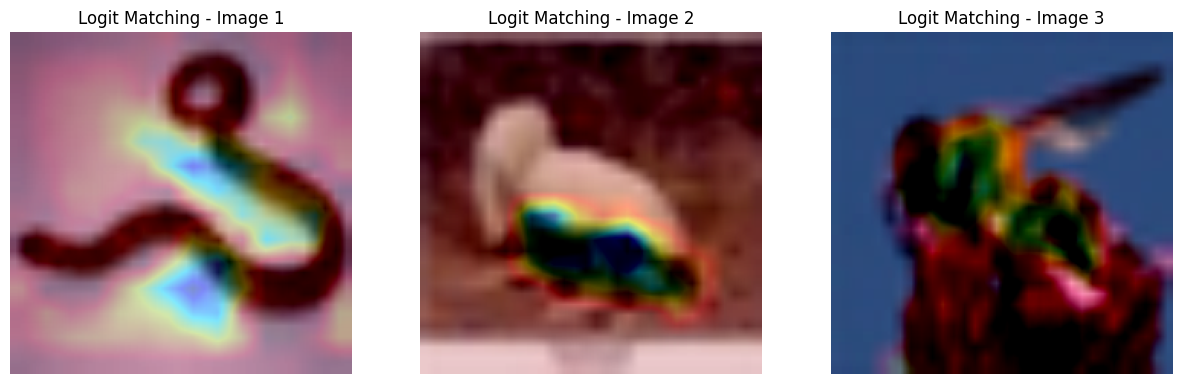

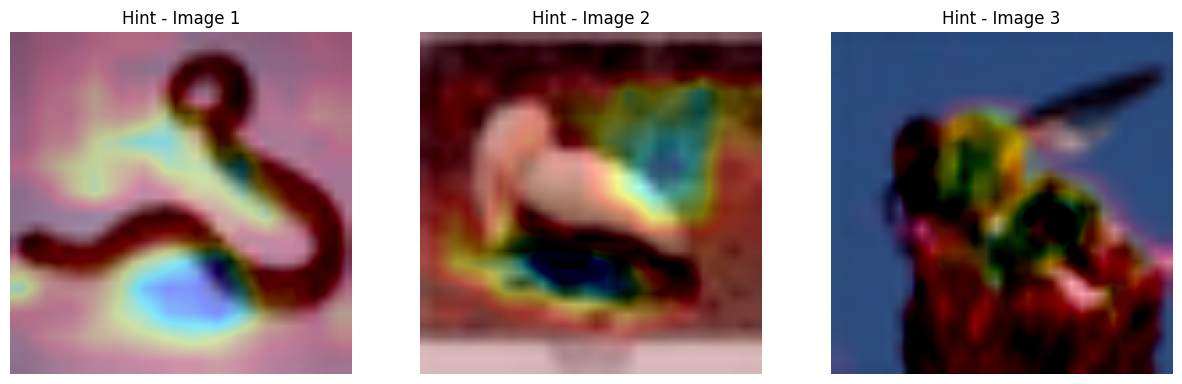

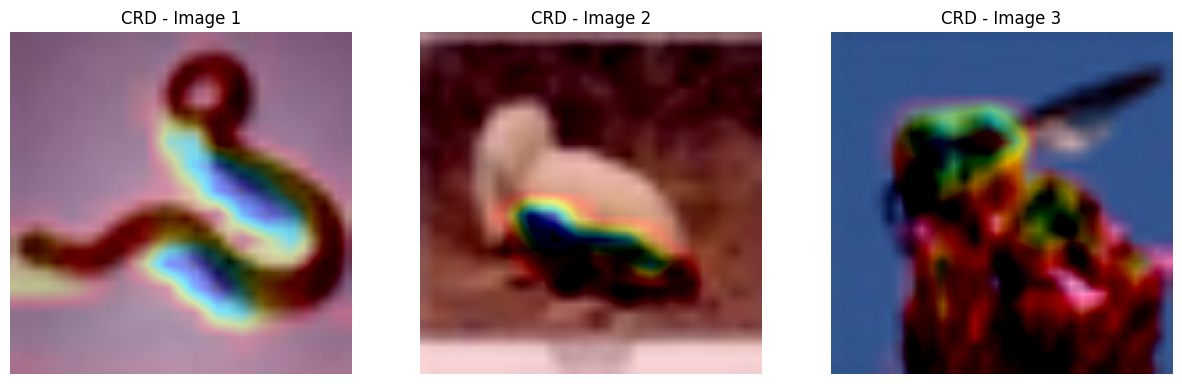

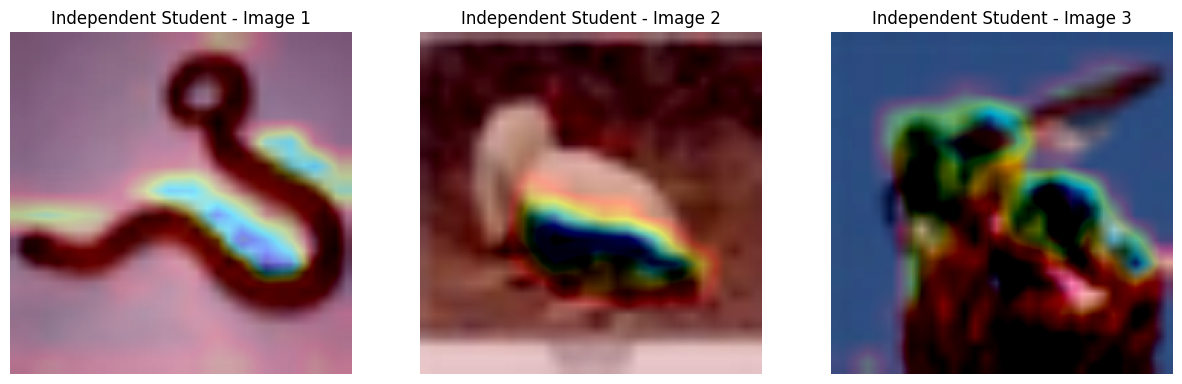

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

def generate_gradcam_heatmap(model, target_layer, input_tensor, class_idx=None):
    model.eval()
    gradients = []
    activations = []

    # Define hooks
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks on the target layer
    handle_forward = target_layer.register_forward_hook(forward_hook)
    handle_backward = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(input_tensor)
    if class_idx is None:
        class_idx = output.argmax().item()

    # Backward pass for the specified class
    model.zero_grad()
    output[:, class_idx].backward()

    # Verify if hooks were called
    if not gradients:
        print("Gradients list is empty. Check if target layer is correctly set and accessible.")
    if not activations:
        print("Activations list is empty. Check if target layer is correctly set and accessible.")

    # Generate GradCAM only if gradients and activations are available
    if gradients and activations:
        gradient = gradients[0].cpu().data.numpy()[0]
        activation = activations[0].cpu().data.numpy()[0]

        weights = np.mean(gradient, axis=(1, 2))  # Average gradients spatially
        cam = np.sum(weights[:, np.newaxis, np.newaxis] * activation, axis=0)

        # Post-process the heatmap
        cam = np.maximum(cam, 0)  # ReLU to retain only positive influences
        cam = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[3]))
        cam -= cam.min()

        # cam /= cam.max()  # Normalize between 0 and 1

        # Normalize between 0 and 1, handling the case where cam.max() is 0
        if cam.max() != 0:
            cam /= cam.max()
        else:
            cam = np.zeros_like(cam)  # Set cam to zeros if max is 0

    else:
        cam = None  # Return None if GradCAM cannot be computed

    # Remove hooks
    handle_forward.remove()
    handle_backward.remove()

    return cam

# Function to plot GradCAM results for each model and each image
def plot_gradcam_row(images, heatmaps, titles):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))
    for i in range(num_images):
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmaps[i]), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam_image = heatmap + np.float32(images[i])
        cam_image = np.clip(cam_image / np.max(cam_image), 0, 1)  # Clip values to [0, 1] range

        axes[i].imshow(cam_image)
        axes[i].set_title(titles[i])
        axes[i].axis('off')
    plt.show()


# Generate GradCAM for each model and each of the three images
for model_name, model in students.items():
    target_layer = model.features[18]  # Adjust target layer as needed for each student model

    images = []
    heatmaps = []
    titles = []
    for i in range(3):  # Assuming you have three images in `selected_images`
        image_tensor = selected_images[i].unsqueeze(0)  # Add batch dimension
        image_np = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

        # Generate GradCAM heatmap
        cam = generate_gradcam_heatmap(model, target_layer, image_tensor)
        if cam is not None:
            images.append(image_np)
            heatmaps.append(cam)
            titles.append(f"{model_name} - Image {i+1}")
        else:
            print(f"GradCAM failed for {model_name} on Image {i+1}")

    # Display GradCAM results in a row for each model
    plot_gradcam_row(images, heatmaps, titles)

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def compare_heatmaps(heatmap1, heatmap2):
    # Rescale heatmaps to 0-255 and convert to uint8
    heatmap1 = (255 * heatmap1).astype(np.uint8)
    heatmap2 = (255 * heatmap2).astype(np.uint8)

    # Calculate SSIM between two heatmaps
    ssim_score = ssim(heatmap1, heatmap2)
    return ssim_score

# Define the target layer for the teacher model
teacher_target_layer = teacher_model.features[28]
image_tensors = [selected_images[i].unsqueeze(0).to('cuda') for i in range(3)]  # Three images
image_labels = [selected_labels[i].unsqueeze(0).to('cuda') for i in range(3)]
for tensor in image_tensors:
    tensor.requires_grad = True

# Calculate and store SSIM for each KD method compared to the teacher
ssim_scores = {model_name: [] for model_name in students.keys()}

# Iterate over each image
for i, image_tensor in enumerate(image_tensors):
    # Generate teacher heatmap
    teacher_heatmap = generate_gradcam_heatmap(teacher_model, teacher_target_layer, image_tensor)

    # Generate student heatmaps and calculate SSIM for each model
    for model_name, model in students.items():
        target_layer = model.features[18]  # Adjust layer based on each student's architecture
        student_heatmap = generate_gradcam_heatmap(model, target_layer, image_tensor)
        ssim_score = compare_heatmaps(teacher_heatmap, student_heatmap)
        ssim_scores[model_name].append(ssim_score)

# Calculate and print the average SSIM score for each model across three images
print("Average SSIM Scores (Teacher vs. Students):")
for model_name, scores in ssim_scores.items():
    avg_score = np.mean(scores)
    print(f"{model_name}: {avg_score:.4f}")
    for idx, score in enumerate(scores):
        print(f"  Image {idx + 1} SSIM: {score:.4f}")

Average SSIM Scores (Teacher vs. Students):
Logit Matching: 0.4309
  Image 1 SSIM: 0.3334
  Image 2 SSIM: 0.4505
  Image 3 SSIM: 0.5088
Hint: 0.4189
  Image 1 SSIM: 0.3548
  Image 2 SSIM: 0.3358
  Image 3 SSIM: 0.5660
CRD: 0.3851
  Image 1 SSIM: 0.2627
  Image 2 SSIM: 0.4235
  Image 3 SSIM: 0.4692
Independent Student: 0.4148
  Image 1 SSIM: 0.3120
  Image 2 SSIM: 0.4872
  Image 3 SSIM: 0.4454


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import torch
from tqdm import tqdm

def compare_heatmaps(heatmap1, heatmap2):
    # Rescale heatmaps to 0-255 and convert to uint8
    heatmap1 = np.nan_to_num(heatmap1)  # Replace NaNs with 0
    heatmap2 = np.nan_to_num(heatmap2)

    heatmap1 = (255 * heatmap1).astype(np.uint8)
    heatmap2 = (255 * heatmap2).astype(np.uint8)

    # Calculate SSIM between two heatmaps
    ssim_score = ssim(heatmap1, heatmap2)
    return ssim_score

# Define the target layer for the teacher model
teacher_target_layer = teacher_model.features[28]
ssim_scores = {model_name: [] for model_name in students.keys()}

# Calculate total number of iterations for the progress bar
total_images = len(test_loader.dataset) * len(students)

# Single tqdm progress bar tracking overall progress
with tqdm(total=total_images, desc="Processing") as pbar:
    for model_name, model in students.items():
        target_layer = model.features[18]  # Adjust layer based on each student's architecture

        # Iterate over the test loader
        for images, _ in test_loader:
            images = images.to('cuda')

            # Iterate through each image in the batch
            for i in range(images.size(0)):
                image_tensor = images[i].unsqueeze(0)  # Add batch dimension
                image_tensor.requires_grad = True

                # Generate teacher heatmap
                teacher_heatmap = generate_gradcam_heatmap(teacher_model, teacher_target_layer, image_tensor)

                # Generate student heatmap and calculate SSIM
                student_heatmap = generate_gradcam_heatmap(model, target_layer, image_tensor)
                ssim_score = compare_heatmaps(teacher_heatmap, student_heatmap)
                ssim_scores[model_name].append(ssim_score)

                # Update the progress bar
                pbar.update(1)

# Calculate and print the average SSIM score for each model across the test loader
print("\n Average SSIM Scores (Teacher vs. Students) over the test set:")
for model_name, scores in ssim_scores.items():
    avg_score = np.mean(scores)
    print(f"{model_name}: {avg_score:.4f}")

Processing: 100%|██████████| 40000/40000 [11:03<00:00, 60.32it/s]


 Average SSIM Scores (Teacher vs. Students) over the test set:
Logit Matching: 0.2855
Hint: 0.2946
CRD: 0.2767
Independent Student: 0.2770


The SSIM scores provide insight into the similarity between the focus areas (as highlighted by GradCAM) of each student model and the teacher model. Here’s a breakdown of the results:

### Hint-based Distillation:

The hint-based student model achieved the highest SSIM score at 0.2946, indicating that it aligns most closely with the teacher model’s focus on image regions relevant for classification. This suggests that hint-based distillation effectively helps the student model mimic the teacher’s attention to significant image areas better than other KD methods and the independent student.

### Logit Matching:

The logit matching student model follows closely with an SSIM score of 0.2855. While slightly lower than hint-based distillation, this score indicates that logit matching also supports alignment of the student’s focus with the teacher’s, though to a lesser degree. It is still better than the CRD and independent models, suggesting that it contributes positively to focus alignment.

### Contrastive Representation Distillation (CRD):

The CRD model has an SSIM score of 0.2767, which is closer to the independent student model than the hint-based or logit matching students. This score suggests that CRD may be less effective in transferring the teacher’s localization patterns, focusing on important features to a lesser extent than the other KD methods.

### Independent Student:

With an SSIM score of 0.2770, the independent student model performs similarly to CRD, indicating that without KD, the student model’s focus is relatively dispersed or misaligned compared to the teacher’s. This score underscores that the independent student lacks the focused localization seen in hint-based and logit matching models.

### Summary and Analysis

The hint-based and logit matching KD approaches contribute the most to helping the student models replicate the teacher’s focus on relevant image regions. Hint-based distillation is particularly effective, resulting in the highest SSIM alignment with the teacher model’s GradCAM visualizations. This suggests that KD methods, especially hint-based distillation, facilitate better feature localization within the student models, supporting closer replication of the teacher’s attention on crucial areas for classification.

## Task 3.5: Checking for Color Invariance with CRD

Colour-Jittered Data

In [ ]:
color_jitter = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
transform = transforms.Compose([
    color_jitter,
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),  # CIFAR-100 mean and std
])

# Load the training dataset with color jitter
train_dataset_jittered = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_loader_jittered = DataLoader(train_dataset_jittered, batch_size=128, shuffle=True)

# Apply color jitter transform to the validation set
val_dataset_jittered = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
val_loader_jittered = DataLoader(val_dataset_jittered, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
jittered_teacher_model = models.vgg16(pretrained=True)
jittered_teacher_model.classifier[6] = nn.Linear(4096, 100)
jittered_teacher_model = jittered_teacher_model.to('cuda')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 224MB/s]


Epoch [3/3]: 100%|██████████| 391/391 [02:02<00:00,  3.19batch/s, loss=1.07]


Teacher model fine-tuning complete.


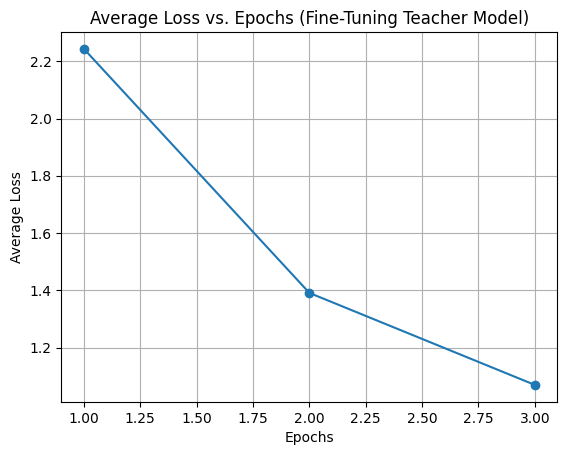

In [ ]:
# Finetune the teacher model on the jittered dataset
prepare_for_finetuning(jittered_teacher_model)
fine_tune_teacher(jittered_teacher_model, train_loader_jittered, num_epochs)

In [ ]:
# torch.save(jittered_teacher_model, "/content/drive/MyDrive/jittered_teacher_model.pth")

In [ ]:
# jittered_teacher_model = torch.load("/content/drive/MyDrive/jittered_teacher_model.pth")

In [ ]:
# Evaluate the color-invariant teacher model on the color-jittered validation set
jittered_teacher_acc = evaluate(jittered_teacher_model, val_loader_jittered)
print(f"Teacher Model Performance on Color-Jittered Validation Set: {jittered_teacher_acc:.2f}%")

Teacher Model Performance on Color-Jittered Validation Set: 62.76%


In [ ]:
LM_jittered_student = models.vgg11()
LM_jittered_student.classifier[6] = nn.Linear(4096, 100)
LM_jittered_student = LM_jittered_student.to('cuda')

hint_jittered_student = models.vgg11()
hint_jittered_student.classifier[6] = nn.Linear(4096, 100)
hint_jittered_student = hint_jittered_student.to('cuda')

crd_jittered_student = models.vgg11()
crd_jittered_student.classifier[6] = nn.Linear(4096, 100)
crd_jittered_student = crd_jittered_student.to('cuda')

Epoch [3/3]: 100%|██████████| 391/391 [02:25<00:00,  2.68batch/s, loss=4.78]

Training complete.


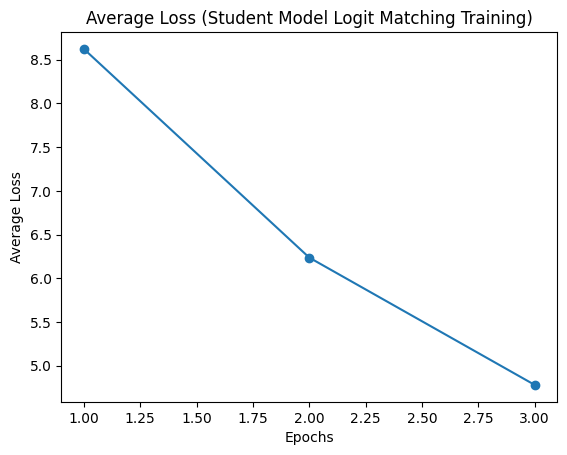

In [ ]:
# Train the student model with LM-based KD Using Normal Dataset (Without Jitter)
distillation_loss_fn = DistillationLoss(TEMPERATURE)
train_LM(LM_jittered_student, jittered_teacher_model, train_loader, distillation_loss_fn, num_epochs)

Hint Training Epoch [3/3]: 100%|██████████| 391/391 [02:52<00:00,  2.26batch/s, loss=7.6]


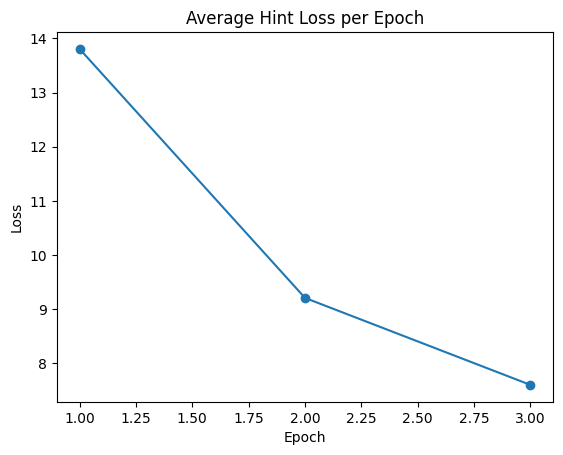

In [ ]:
# Train the student model with hint-based KD Using Normal Dataset (Without Jitter)
train_hint(hint_jittered_student, jittered_teacher_model, regressor, train_loader, num_epochs)

Epoch [3/3]: 100%|██████████| 391/391 [03:10<00:00,  2.05batch/s, loss=11.9]

Training complete.


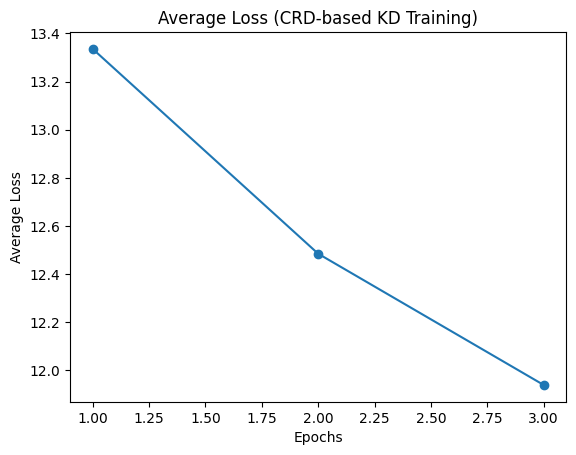

In [ ]:
# Train the student model with CRD-based KD Using Normal Dataset (Without Jitter)
train_CRD(crd_jittered_student, jittered_teacher_model, train_loader, num_epochs)

In [ ]:
# torch.save(LM_jittered_student, "/content/drive/MyDrive/LM_jittered_student.pth")
# torch.save(hint_jittered_student, "/content/drive/MyDrive/hint_jittered_student.pth")
# torch.save(crd_jittered_student, "/content/drive/MyDrive/crd_jittered_student.pth")

In [ ]:
# LM_jittered_student = torch.load("/content/drive/MyDrive/LM_jittered_student.pth")
# hint_jittered_student = torch.load("/content/drive/MyDrive/hint_jittered_student.pth")
# crd_jittered_student = torch.load("/content/drive/MyDrive/crd_jittered_student.pth")

In [ ]:
# Evaluate student model on color-jittered validation set
LM_student_acc = evaluate(LM_jittered_student, val_loader_jittered)
print(f"LM Student Performance on Color-Jittered Validation Set: {LM_student_acc:.2f}%")

hint_student_acc = evaluate(hint_jittered_student, val_loader_jittered)
print(f"hint Student Performance on Color-Jittered Validation Set: {hint_student_acc:.2f}%")

crd_student_acc = evaluate(crd_jittered_student, val_loader_jittered)
print(f"CRD Student Performance on Color-Jittered Validation Set: {crd_student_acc:.2f}%")

LM Student Performance on Color-Jittered Validation Set: 36.53%
hint Student Performance on Color-Jittered Validation Set: 42.29%
CRD Student Performance on Color-Jittered Validation Set: 29.95%


The results show a clear contrast in the performance of each student model on the color-jittered validation set, indicating varying degrees of color invariance achieved through different KD methods:

### Teacher Model:

Achieving 62.76% accuracy, the teacher model, fine-tuned on color-jittered data, demonstrates strong color invariance, as expected. This high performance suggests it has effectively learned to focus on features that are robust to color variations.

### Hint-based Student:

With an accuracy of 42.29%, the hint-based student model shows the highest performance among the KD-based students on the color-jittered validation set. This result implies that the hint-based KD method supports some degree of color invariance in the student model, likely due to its focus on intermediate feature alignment that may implicitly capture color-agnostic representations.

### Logit Matching Student:

The logit matching student model, with an accuracy of 36.53%, performs somewhat well, though it does not match the color invariance seen in the hint-based model. This lower score indicates that while logit matching supports learning some features from the teacher, it may not effectively transfer the color invariance property.

### CRD Student:

The CRD student model has the lowest performance at 29.95%, suggesting minimal color invariance. This lower score implies that CRD, focused on contrastive learning of representation similarities, may not transfer the teacher’s robustness to color variations as effectively as hint-based or logit matching KD.

### Analysis

The results indicate that CRD does not significantly help the student model achieve color invariance when evaluated on a color-jittered validation set. Among the KD methods, hint-based distillation is the most effective at transferring color invariance, followed by logit matching. This suggests that focusing on intermediate feature alignment (as in hint-based KD) may enable the student to learn more robust, color-agnostic representations. In contrast, the CRD approach may not be as effective in replicating the teacher’s color invariance, likely due to its emphasis on contrasting representations rather than explicitly aligning them in the feature space.

## Task 3.6: Testing the Efficacy of a Larger Teacher

### VGG-19 Finetuning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define and Fine-Tune VGG-19 Teacher Model
vgg19_teacher = models.vgg19(pretrained=True)
vgg19_teacher.classifier[6] = nn.Linear(4096, 100)  # Adjust for CIFAR-100
vgg19_teacher = vgg19_teacher.to('cuda')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 207MB/s]


Epoch [3/3]: 100%|██████████| 391/391 [01:44<00:00,  3.73batch/s, loss=0.65]


Teacher model fine-tuning complete.


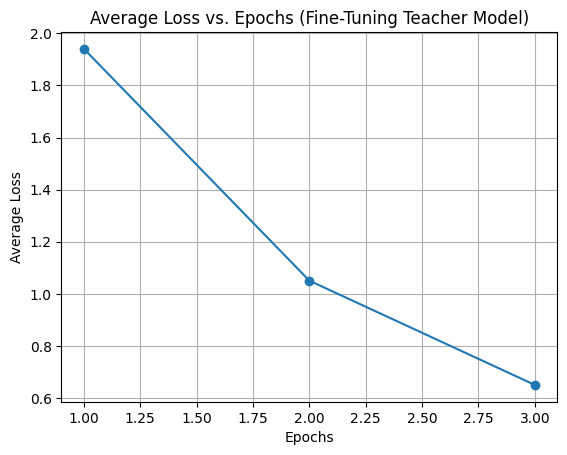

In [ ]:
prepare_for_finetuning(vgg19_teacher)

fine_tune_teacher(vgg19_teacher, train_loader, num_epochs)

In [ ]:
teacher_acc = evaluate(vgg19_teacher, test_loader)
print(f"VGG19 Teacher Performance on Test Set: {teacher_acc:.2f}%")

VGG19 Teacher Performance on Test Set: 67.62%


### Three Students

In [ ]:
# Define VGG-11 Student Models for Each KD Technique
# Logit Matching Student
LM_student = models.vgg11()
LM_student.classifier[6] = nn.Linear(4096, 100)
LM_student = LM_student.to('cuda')

# Hint-Based Distillation Student
hint_student = models.vgg11()
hint_student.classifier[6] = nn.Linear(4096, 100)
hint_student = hint_student.to('cuda')

# CRD Student
CRD_student = models.vgg11()
CRD_student.classifier[6] = nn.Linear(4096, 100)
CRD_student = CRD_student.to('cuda')

### Train Three Students

Epoch [3/3]: 100%|██████████| 391/391 [02:29<00:00,  2.62batch/s, loss=5.26]

Training complete.


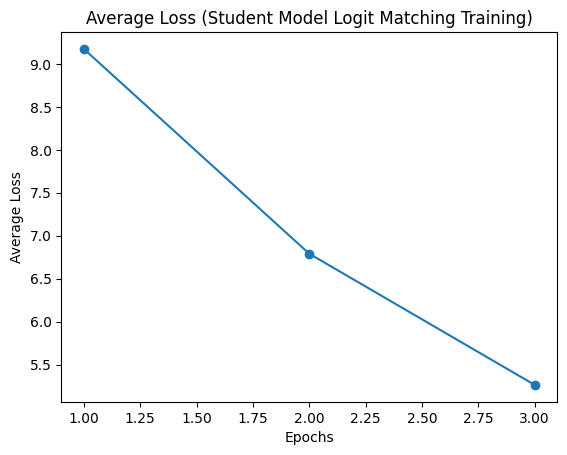

In [ ]:
# Initialize Distillation Loss for Logit Matching
distillation_loss_fn = DistillationLoss(TEMPERATURE)

# Train Logit Matching Student
train_LM(LM_student, vgg19_teacher, train_loader, distillation_loss_fn, num_epochs)

Hint Training Epoch [3/3]: 100%|██████████| 391/391 [02:54<00:00,  2.24batch/s, loss=7.99]


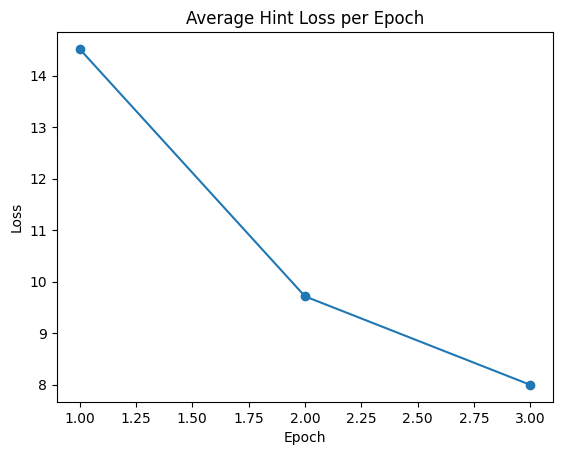

In [ ]:
# Train Hint-Based Distillation Student
HINT_LAYER_TEACHER = 19  # Middle Layer
GUIDED_LAYER_STUDENT = 11  # Middle layer for VGG-11
regressor = HintRegressor(student_dim=128, teacher_dim=256).to('cuda')

train_hint(hint_student, vgg19_teacher, regressor, train_loader, num_epochs, hint_weight=0.5)

Epoch [5/5]: 100%|██████████| 391/391 [03:19<00:00,  1.96batch/s, loss=10.8]

Training complete.


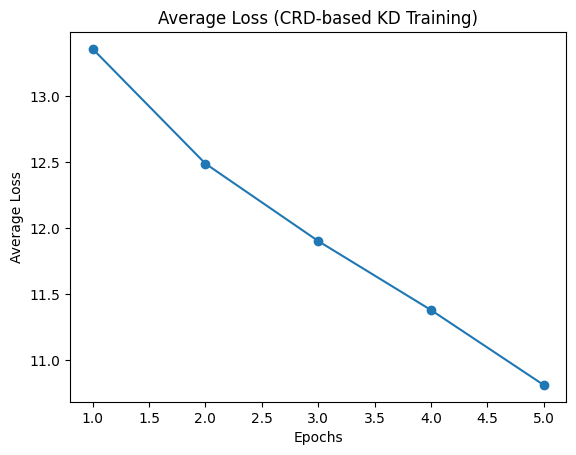

In [ ]:
# Train CRD Student
# s_dim, t_dim, feat_dim, nce_n, nce_t, nce_mom, n_data = 4096, 4096, 128, 4096, 0.07, 0.5, len(train_dataset)
# crd_distillation = CRD(s_dim, t_dim, feat_dim, nce_n, TEMPERATURE, nce_mom, n_data).cuda()
train_CRD(CRD_student, vgg19_teacher, train_loader, num_epochs=5)

### Evaluate Three Students

In [ ]:
# Evaluation of each model
LM_student_acc = evaluate(LM_student, test_loader)
print(f"Logit Matching Student Performance on Test Set: {LM_student_acc:.2f}%")

hint_student_acc = evaluate(hint_student, test_loader)
print(f"Hint-Based Student Performance on Test Set: {hint_student_acc:.2f}%")

CRD_student_acc = evaluate(CRD_student, test_loader)
print(f"CRD Student Performance on Test Set: {CRD_student_acc:.2f}%")

Logit Matching Student Performance on Test Set: 41.37%
Hint-Based Student Performance on Test Set: 47.18%
CRD Student Performance on Test Set: 47.62%


The results reveal some interesting differences in the performance of VGG-11 student models trained with VGG-16 and VGG-19 teachers. Here’s a breakdown:

## Comparison of Student Performance with VGG-16 and VGG-19 Teachers

### Logit Matching Student:

VGG-16 Teacher: 42.27%

VGG-19 Teacher: 41.37%

Analysis:

The student’s performance with the VGG-19 teacher shows a slight decrease compared to the VGG-16 teacher. This suggests that the larger teacher did not translate into a meaningful improvement for the logit matching student. The similarity in accuracy implies that the increased complexity of the VGG-19 teacher may not significantly affect the logit matching KD process.

### Hint-Based Student:

VGG-16 Teacher: 47.97%

VGG-19 Teacher: 47.18%

Analysis:

The hint-based student model also experienced a minor decrease in accuracy with the VGG-19 teacher. Since hint-based KD focuses on intermediate feature alignment, it appears that the added layers and parameters in VGG-19 did not substantially enhance the student’s ability to generalize. The performance remains close between the two teachers, indicating that the teacher’s size may have limited impact on this KD method.

### CRD Student:

VGG-16 Teacher: 38.86%

VGG-19 Teacher: 47.62%

Analysis:

The CRD student shows a notable improvement, jumping from 38.86% with the VGG-16 teacher to 47.62% with the VGG-19 teacher. This significant increase suggests that CRD benefits more from the added representational capacity of the larger teacher, possibly because CRD relies on contrasting a greater number of learned representations, which a larger teacher can better provide.

### Summary and Analysis

Overall, the VGG-19 teacher model led to marginal improvements for the logit matching and hint-based students but resulted in a substantial gain for the CRD student. This suggests that the size of the teacher model can play an important role in KD efficacy, but its impact varies by KD approach:

For logit matching and hint-based distillation, the larger teacher did not significantly impact student performance, indicating that these methods may not require an exceptionally large teacher to transfer knowledge effectively.
For CRD, the larger teacher model appears to enhance performance by providing a richer set of representations, which aligns with CRD’s contrastive learning approach.

In summary, while the teacher’s size has limited impact on some KD methods, it can significantly enhance others, like CRD, that benefit from a broader and more nuanced feature space provided by a larger teacher model.

## Summary of Results

In [4]:
from tabulate import tabulate

# Consolidated data table
data = [
    # Accuracy Comparison
    ["Metric", "VGG-16 Teacher", "Logit Matching", "Hint-Based", "CRD", "Smoothed Teacher Logits", "DKD"],
    ["Accuracy (%) - VGG-16 Teacher with VGG-11 Student", 67.78, 42.27, 47.97, 38.86, 38.69, 41.06],
    ["Accuracy (%) - VGG-19 Teacher with VGG-11 Student", 67.62, 41.37, 47.18, 47.62, "-", "-"],

    # KL Divergence Scores
    ["KL Divergence (Average over Query Images)", "-", 0.4552, 0.4829, 0.5995, "-", "-"],

    # SSIM Scores
    ["SSIM Score (Average)", "-", 0.2855, 0.2946, 0.2767, "-", "-"],

    # Color-Jittered Validation Set Performance
    ["Color-Jittered Validation Set Accuracy (%) - VGG-16 Teacher", 62.76, 36.53, 42.29, 29.95, "-", "-"]
]

# Print consolidated table
print("Consolidated Results Table:\n")
print(tabulate(data, headers="firstrow", tablefmt="fancy_grid"))

Consolidated Results Table:

╒═════════════════════════════════════════════════════════════╤══════════════════╤══════════════════╤══════════════╤═════════╤═══════════════════════════╤═══════╕
│ Metric                                                      │ VGG-16 Teacher   │   Logit Matching │   Hint-Based │     CRD │ Smoothed Teacher Logits   │ DKD   │
╞═════════════════════════════════════════════════════════════╪══════════════════╪══════════════════╪══════════════╪═════════╪═══════════════════════════╪═══════╡
│ Accuracy (%) - VGG-16 Teacher with VGG-11 Student           │ 67.78            │          42.27   │      47.97   │ 38.86   │ 38.69                     │ 41.06 │
├─────────────────────────────────────────────────────────────┼──────────────────┼──────────────────┼──────────────┼─────────┼───────────────────────────┼───────┤
│ Accuracy (%) - VGG-19 Teacher with VGG-11 Student           │ 67.62            │          41.37   │      47.18   │ 47.62   │ -                         │ -

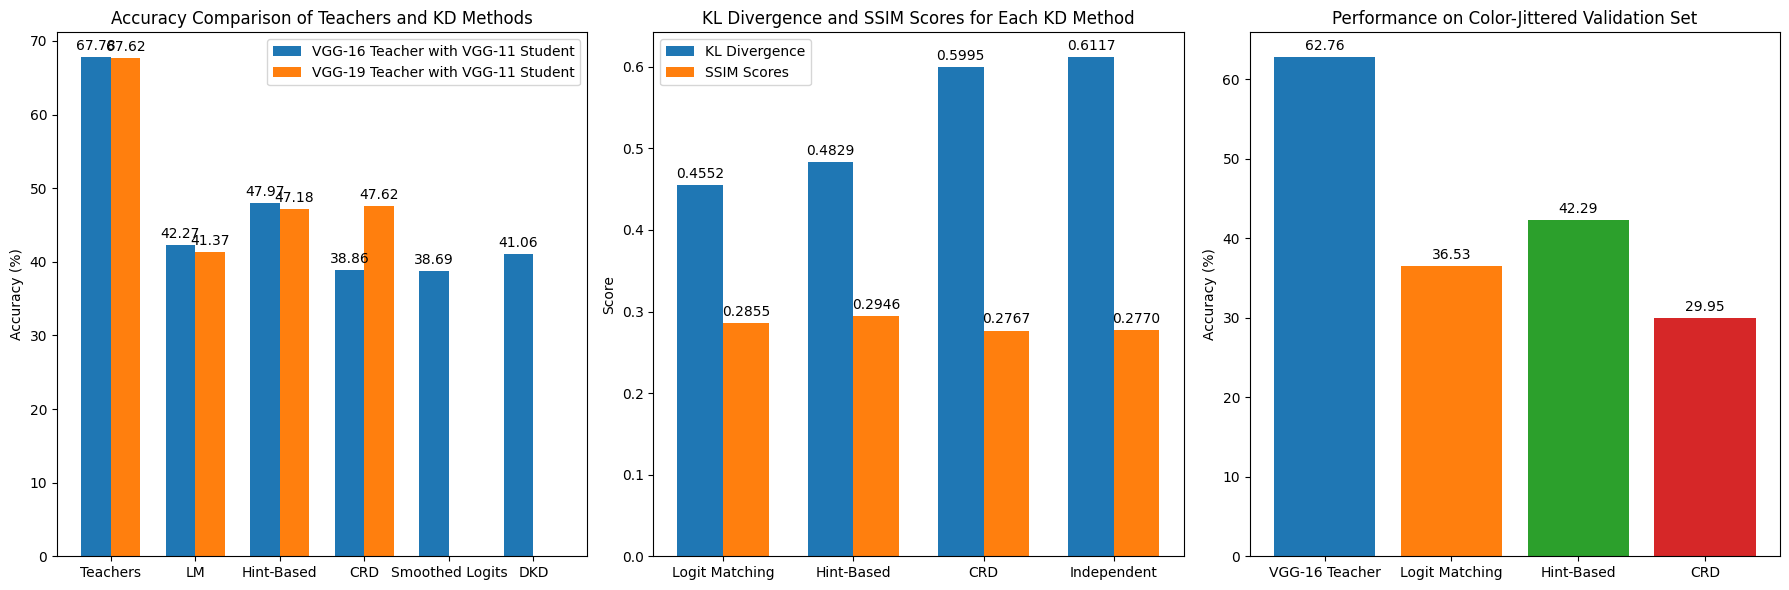

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Data for accuracy comparison
labels = ['Teachers', 'LM', 'Hint-Based', 'CRD', 'Smoothed Logits', 'DKD']
vgg16_teacher = [67.78, 42.27, 47.97, 38.86, 38.69, 41.06]
vgg19_teacher = [67.62, 41.37, 47.18, 47.62, 0, 0]

# Data for KL Divergence and SSIM Scores
kl_divergence = [0.4552, 0.4829, 0.5995, 0.6117]
ssim_scores = [0.2855, 0.2946, 0.2767, 0.2770]
methods = ['Logit Matching', 'Hint-Based', 'CRD', 'Independent']

# Data for Color-Jittered Validation Set Performance
jitter_labels = ['VGG-16 Teacher', 'Logit Matching', 'Hint-Based', 'CRD']
jitter_values = [62.76, 36.53, 42.29, 29.95]

# Set up subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 1. Bar Graph for Accuracy Comparison
x = np.arange(len(labels))
width = 0.35

bars_vgg16 = axs[0].bar(x - width/2, vgg16_teacher, width, label='VGG-16 Teacher with VGG-11 Student')
bars_vgg19 = axs[0].bar(x + width/2, vgg19_teacher, width, label='VGG-19 Teacher with VGG-11 Student')

axs[0].set_ylabel('Accuracy (%)')
axs[0].set_title('Accuracy Comparison of Teachers and KD Methods')
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels)
axs[0].legend()

# Annotate bars for accuracy graph
for bars in [bars_vgg16, bars_vgg19]:
    for bar in bars:
        height = bar.get_height()
        if height is not None and height != 0:
            axs[0].annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # Offset text position above bar
                            textcoords="offset points",
                            ha='center', va='bottom')

# 2. Bar Graph for KL Divergence and SSIM Scores
x = np.arange(len(methods))

bars_kl = axs[1].bar(x - width/2, kl_divergence, width, label='KL Divergence')
bars_ssim = axs[1].bar(x + width/2, ssim_scores, width, label='SSIM Scores')

axs[1].set_ylabel('Score')
axs[1].set_title('KL Divergence and SSIM Scores for Each KD Method')
axs[1].set_xticks(x)
axs[1].set_xticklabels(methods)
axs[1].legend()

# Annotate bars for KL and SSIM scores
for bars in [bars_kl, bars_ssim]:
    for bar in bars:
        height = bar.get_height()
        axs[1].annotate(f'{height:.4f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

# 3. Bar Graph for Color-Jittered Validation Set Performance
bars_jitter = axs[2].bar(jitter_labels, jitter_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

axs[2].set_ylabel('Accuracy (%)')
axs[2].set_title('Performance on Color-Jittered Validation Set')
axs[2].set_xticks(np.arange(len(jitter_labels)))
axs[2].set_xticklabels(jitter_labels)

# Annotate bars for color-jittered performance
for bar in bars_jitter:
    height = bar.get_height()
    axs[2].annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Adjust layout and show
plt.tight_layout()
plt.show()